In [238]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

import seaborn as sns
import matplotlib.pyplot as plt
import sys

import skimage
from skimage.color import rgb2hsv
from skimage.transform import rescale, resize
from tqdm import tqdm

import random

random.seed(123456789)


HEIGHT = 50
WIDTH  = 50

SKImage rescales the image for us! Which means that we don't need to rescale by 255.0 anymore, saving us needlessly spent time and effort. There is another Augmentor library which can be used for data augmentation. We can simply sample the augmented images henceforth!

In [239]:
sys.path.append(os.path.dirname(os.path.join((os.path.pardir), "Modules")))

origin_dir = os.path.join(os.path.pardir, 'Data')
new_dir_path = os.path.join(os.path.pardir, 'Data', 'cell_images')

#for local systems
train_csv = os.path.join(origin_dir, 'train.csv')
test_csv = os.path.join(origin_dir, 'test.csv')
val_csv = os.path.join(origin_dir, 'val.csv')

from Modules.data_download import Data_Download
from Modules.labelling import Labelling

# download = Data_Download(origin_dir)
# data_dir = download.resize_image(new_dir_path, 44, 44)

lab = Labelling()
lab.label('../Data/cell_images/', exclude_mislabeled= True)      # function to label the dataset
train_csv, val_csv, test_csv = lab.train_test_val_split('../Data/', '../Data/cell_images/labels.csv', random_state = 12345)

In [240]:
train_data = pd.read_csv(train_csv)
val_data   = pd.read_csv(val_csv)
test_data  = pd.read_csv(test_csv)

### Reading images

In [241]:
def read_image(path):
    '''Function to read images given a path and return an array'''
    return skimage.io.imread(path)

../Data/cell_images/Parasitized\C132P93ThinF_IMG_20151004_152257_cell_111.png
1.0


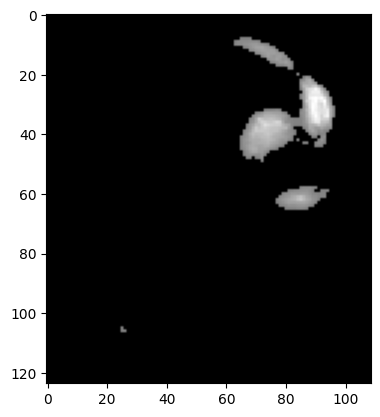

In [242]:
i = 14

print(train_data['Image_Path'][i])
image = rgb2hsv(skimage.io.imread(train_data['Image_Path'][i]))
print(np.max(image))
result = ((image > 0.5)*image)[..., 1]
plt.imshow(result, 'gray')

In [243]:
tqdm.pandas()
train_data['image_arr'] = train_data['Image_Path'].progress_apply(lambda x: read_image(x))
val_data['image_arr']   = val_data['Image_Path'].progress_apply(lambda x: read_image(x))
test_data['image_arr']  = test_data['Image_Path'].progress_apply(lambda x: read_image(x))


x_train, y_train = train_data['image_arr'].to_numpy(), train_data['Parasitized'].to_numpy()
x_val  , y_val   = val_data['image_arr'].to_numpy()  , val_data['Parasitized'].to_numpy()
x_test , y_test  = test_data['image_arr'].to_numpy() , test_data['Parasitized'].to_numpy()

100%|██████████| 2617/2617 [00:02<00:00, 1024.03it/s]


## Data Augmentation

In [244]:
import albumentations as A
import cv2

In [245]:
augment = A.augmentations.geometric.transforms.Affine(
    scale = 0.5,
    translate_percent = 0.1,
    rotate = 60,
    shear = 30
    )

augment = A.ShiftScaleRotate(scale_limit = (-0.5, 0.01),rotate_limit= 180, border_mode=cv2.BORDER_CONSTANT, always_apply= True)

transform = A.Compose(
    [augment,
    A.VerticalFlip(p = 0.5),
    A.HorizontalFlip(p = 0.5),
    A.augmentations.geometric.Affine(shear = 30),
    A.Resize(HEIGHT, WIDTH, always_apply= True)
    ]
)

aug_dataset = []
aug_labels = []
COPIES = 3

for i, lab in tqdm(zip(x_train, y_train)):
    for _ in range(COPIES):
        aug_dataset.append(transform(image = i)['image'])
        aug_labels.append(lab)

20601it [00:31, 659.93it/s]


In [246]:
x_train_aug = np.array(aug_dataset)
y_train_aug = np.array(aug_labels)

### Resizing

In [248]:
temp = []
for img in tqdm(x_train):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_train = np.array(temp)


temp = []
for img in tqdm(x_val):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_val = np.array(temp)


temp = []
for img in tqdm(x_test):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_test = np.array(temp)

100%|██████████| 20601/20601 [01:08<00:00, 300.09it/s]


In [252]:
x_train.shape, x_val.shape, x_test.shape, x_train_aug.shape

((20601, 50, 50, 3), (2943, 50, 50, 3), (2617, 50, 50, 3), (61803, 50, 50, 3))

## Modeling

### Unaugmented

#### Naive Bayes

In [ ]:
from sklearn import naive_bayes

nb_cls = naive_bayes.GaussianNB()